In [339]:
# Basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns=1000
pd.options.display.max_rows=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

import nltk

In [3]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", round(r2_score(y_true, y_pred), 4))
    print("RMSE: ", round((mean_squared_error(y_true, y_pred)) ** 0.5, 4))
    print("MAE: ", round(mean_absolute_error(y_true, y_pred), 4))
    
# For plotting residuals
def res_plot(model_name, X, y_true, y_pred, ncol=None, figsize=(15,8)):
    y_res = y_pred - y_true
    if ncol == None:
        ncol = len(X.columns)
    nrow = int(np.ceil(len(X.columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, c in enumerate(X.columns):
        ax = axes.flatten()[i]
        ax.scatter(X[c], y_res, alpha=0.2)
        ax.axhline(0, c='r', linestyle='--')
        ax.set(xlabel=c, ylabel='y residual')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    fig.suptitle(model_name, y=0)
    fig.tight_layout()
    plt.show()

In [4]:
df = pd.read_excel('training_set_rel3.xlsx', sheet_name='training_set')

In [5]:
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12978 non-null  int64  
 1   essay_set       12978 non-null  int64  
 2   essay           12978 non-null  object 
 3   rater1_domain1  12977 non-null  float64
 4   rater2_domain1  12977 non-null  float64
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12977 non-null  float64
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [7]:
df.shape

(12978, 28)

In [8]:
df.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

In [9]:
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
essay_id,12978
essay_set,8
essay,12974
rater1_domain1,30
rater2_domain1,29
rater3_domain1,16
domain1_score,53
rater1_domain2,4
rater2_domain2,4
domain2_score,4


In [10]:
df[df.essay.duplicated()]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
5149,7549,3,"In the setting of the essay; ""Rough Road Ahead...",1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5290,7690,3,In the essay the features of the setting affec...,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6689,10248,4,The author concludes the story with that parag...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6908,10468,4,The author concluded this paragraph in this st...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = df.loc[~df.essay.duplicated(keep='first'), :]

In [12]:
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
essay_id,12974
essay_set,8
essay,12974
rater1_domain1,30
rater2_domain1,29
rater3_domain1,16
domain1_score,53
rater1_domain2,4
rater2_domain2,4
domain2_score,4


In [13]:
df.domain1_score.unique()

array([ 8.,  9.,  7., 10.,  6., 12.,  4.,  3., 11.,  2.,  5.,  1.,  0.,
       nan, 15., 13., 17., 23., 16., 18., 19., 14., 21., 24., 20., 22.,
       34., 46., 40., 30., 26., 41., 31., 44., 36., 43., 45., 35., 42.,
       33., 38., 47., 32., 50., 39., 37., 55., 60., 28., 49., 29., 27.,
       25., 48.])

In [14]:
df.isna().sum()/len(df)

essay_id          0.000000
essay_set         0.000000
essay             0.000000
rater1_domain1    0.000077
rater2_domain1    0.000077
rater3_domain1    0.990134
domain1_score     0.000077
rater1_domain2    0.861261
rater2_domain2    0.861261
domain2_score     0.861261
rater1_trait1     0.823339
rater1_trait2     0.823339
rater1_trait3     0.823339
rater1_trait4     0.823339
rater1_trait5     0.944273
rater1_trait6     0.944273
rater2_trait1     0.823339
rater2_trait2     0.823339
rater2_trait3     0.823339
rater2_trait4     0.823339
rater2_trait5     0.944273
rater2_trait6     0.944273
rater3_trait1     0.990134
rater3_trait2     0.990134
rater3_trait3     0.990134
rater3_trait4     0.990134
rater3_trait5     0.990134
rater3_trait6     0.990134
dtype: float64

In [15]:
df.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

In [16]:
df2 = df[['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score']].copy()

In [17]:
round(df2.isna().sum()/len(df2)*100, 2)

essay_id          0.00
essay_set         0.00
essay             0.00
rater1_domain1    0.01
rater2_domain1    0.01
domain1_score     0.01
dtype: float64

In [18]:
df2.loc[df2.domain1_score.isna(), :]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
6973,10534,4,"When they come back, Saeng vowed silently to h...",NaN,NaN,NaN


In [19]:
df2 = df2[~df2.domain1_score.isna()]

In [20]:
df2.isna().sum()

essay_id          0
essay_set         0
essay             0
rater1_domain1    0
rater2_domain1    0
domain1_score     0
dtype: int64

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12973 entries, 0 to 12977
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12973 non-null  int64  
 1   essay_set       12973 non-null  int64  
 2   essay           12973 non-null  object 
 3   rater1_domain1  12973 non-null  float64
 4   rater2_domain1  12973 non-null  float64
 5   domain1_score   12973 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 709.5+ KB


In [22]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
essay_id,12973.0,10295.817313,6309.716208,1.0,4438.0,10045.0,15682.0,21633.0
essay_set,12973.0,4.179681,2.137109,1.0,2.0,4.0,6.0,8.0
rater1_domain1,12973.0,4.127804,4.212810,0.0,2.0,3.0,4.0,30.0
rater2_domain1,12973.0,4.138056,4.264604,0.0,2.0,3.0,4.0,30.0
domain1_score,12973.0,6.801511,8.971354,0.0,2.0,3.0,8.0,60.0


<AxesSubplot:>

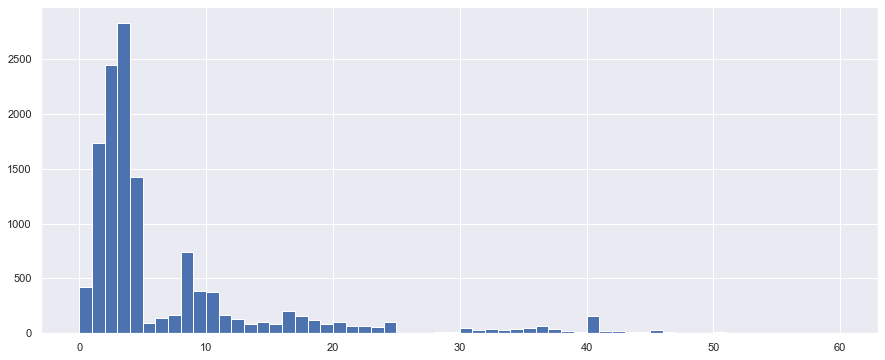

In [23]:
df2.domain1_score.hist(bins=list(range(61)), figsize=(15,6))

In [24]:
df2.iloc[0].T

essay_id                                                          1
essay_set                                                         1
essay             Dear local newspaper, I think effects computer...
rater1_domain1                                                  4.0
rater2_domain1                                                  4.0
domain1_score                                                   8.0
Name: 0, dtype: object

In [25]:
df2.iloc[0,2]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [26]:
len(df2.iloc[0,2])

1875

In [27]:
df2['num_char'] = 0

for i in range(len(df2)):
    df2.iloc[i,-1] = len(df2.iloc[i,2])

<AxesSubplot:>

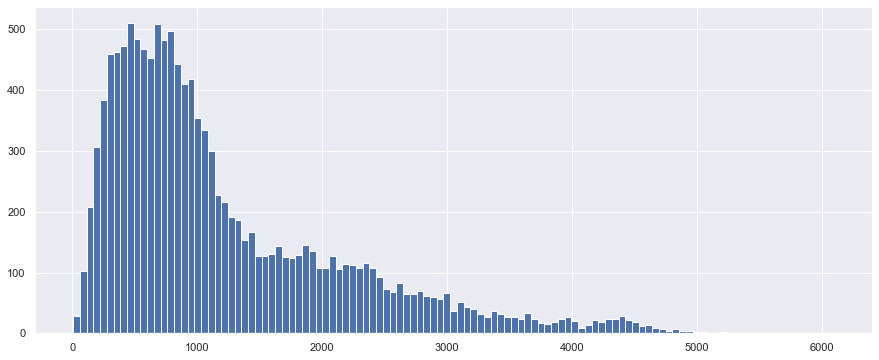

In [28]:
df2.num_char.hist(bins=int(len(df2)**0.5), figsize=(15,6))

In [29]:
len(df2.iloc[0,2].split())

338

In [30]:
df2['num_word'] = 0

for i in range(len(df2)):
    df2.iloc[i,-1] = len(df2.iloc[i,2].split())

<AxesSubplot:>

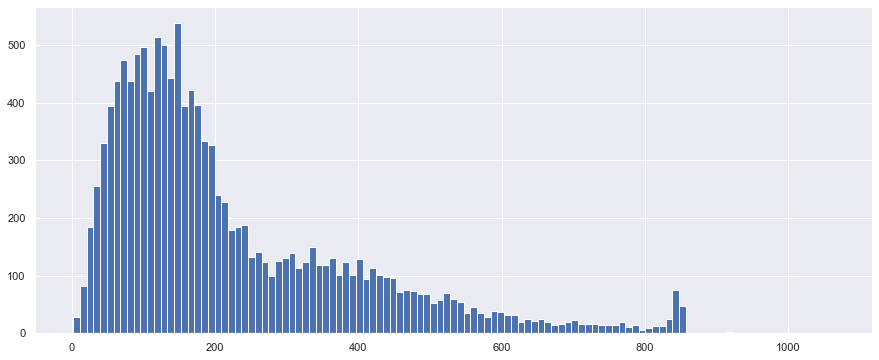

In [31]:
df2.num_word.hist(bins=int(len(df2)**0.5), figsize=(15,6))

In [32]:
df2['avg_word_len'] = df2.num_char / df2.num_word

<AxesSubplot:>

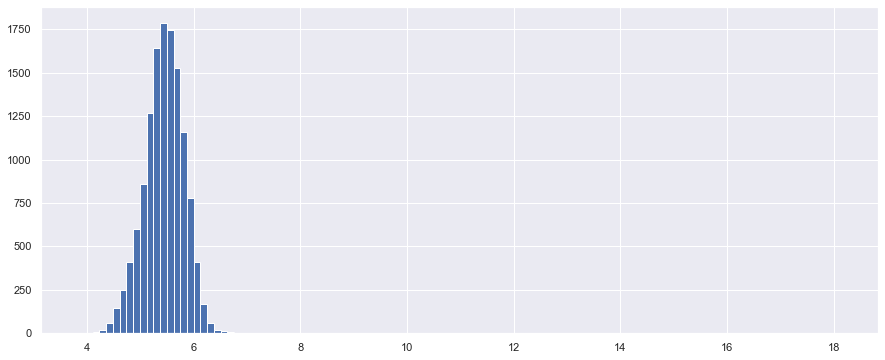

In [33]:
df2.avg_word_len.hist(bins=int(len(df2)**0.5), figsize=(15,6))

In [34]:
df2.avg_word_len.describe()

count    12973.000000
mean         5.446055
std          0.389829
min          3.857143
25%          5.212766
50%          5.459716
75%          5.698113
max         18.120000
Name: avg_word_len, dtype: float64

In [35]:
df2.loc[df2.avg_word_len == df2.avg_word_len.max(), :]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
2779,3974,2,I do not think that censoship has a ightful pl...,2.0,2.0,2.0,906,50,18.12


In [36]:
df2.iloc[2779,2]

'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'

In [37]:
df2.iloc[2779,2] = 'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people.'

In [38]:
df2.iloc[2779,2]

'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people.'

In [39]:
df2.iloc[2779,6] = len(df2.iloc[2779,2])

In [40]:
df2.iloc[2779,7] = len(df2.iloc[2779,2].split())

In [41]:
df2.iloc[2779,8] = df2.iloc[2779,6] / df2.iloc[2779,7]

In [42]:
df2.iloc[2779,:]

essay_id                                                       3974
essay_set                                                         2
essay             I do not think that censoship has a ightful pl...
rater1_domain1                                                  2.0
rater2_domain1                                                  2.0
domain1_score                                                   2.0
num_char                                                        267
num_word                                                         50
avg_word_len                                                   5.34
Name: 2779, dtype: object

<AxesSubplot:>

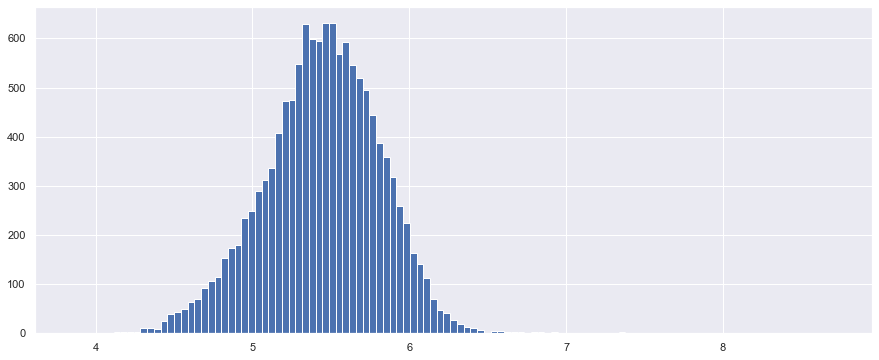

In [43]:
df2['avg_word_len'].hist(bins=int(len(df2)**0.5), figsize=(15,6))

In [44]:
df2.loc[df2['avg_word_len'] == df2['avg_word_len'].max(), :]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
8739,13485,5,The mood created by the author in this memoir ...,3.0,3.0,3.0,1524,175,8.708571


In [45]:
df2.iloc[8739,2]

'In the memoir, Narciso Rodriguez, the author creates a mood of appreciation + happiness. @CAPS1 does this by starting w/ background, + by the end moving to the lessons @CAPS1 learned from his parents.First, @CAPS1 describes how wounderful this enviornment was in paragraph @NUM1. "My young parents created a traditional Cuban home, the very heart of which was the kitchen... My parents passed on to me... a love of cooking that is still with me today (for which I am eternally grateful). Passionate Cuban music (which I adore to this day) filled the air..." @CAPS1 continues by describing how wonderful a place to grow up it was + how his parents showed him genorosity.Next, @CAPS1 says how hard it was for his parents to leave everything they knew, just for their children. In states in paragraph @NUM2, "they came selflessly... to give their children a better life." @CAPS1 continues by writing of how strong they were by showing him the value of family + friends + genorosity. This shows how appr

In [46]:
df_1 = df2[df2.essay_set == 1]
df_2 = df2[df2.essay_set == 2]
df_3 = df2[df2.essay_set == 3]
df_4 = df2[df2.essay_set == 4]
df_5 = df2[df2.essay_set == 5]
df_6 = df2[df2.essay_set == 6]
df_7 = df2[df2.essay_set == 7]
df_8 = df2[df2.essay_set == 8]

In [47]:
df_1.domain1_score.describe()

count    1783.000000
mean        8.528323
std         1.538565
min         2.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: domain1_score, dtype: float64

8.0 8.528323051037576


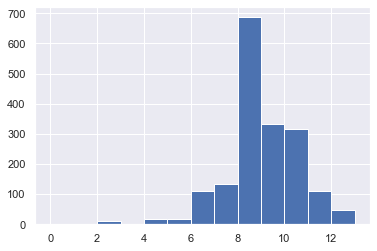

In [48]:
df_1.domain1_score.hist(bins=list(range(14)))
print(df_1.domain1_score.median(), df_1.domain1_score.mean())

In [49]:
df_2.domain1_score.describe()

count    1800.000000
mean        3.415556
std         0.774512
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: domain1_score, dtype: float64

3.0 3.4155555555555557


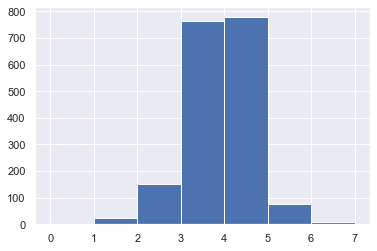

In [50]:
df_2.domain1_score.hist(bins=list(range(8)))
print(df_2.domain1_score.median(), df_2.domain1_score.mean())

In [51]:
df_3.domain1_score.describe()

count    1724.000000
mean        1.848608
std         0.815366
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: domain1_score, dtype: float64

2.0 1.8486078886310904


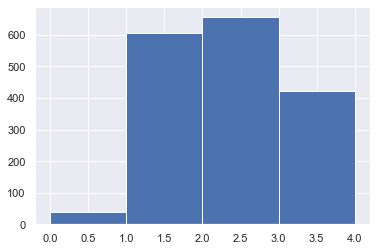

In [52]:
df_3.domain1_score.hist(bins=list(range(5)))
print(df_3.domain1_score.median(), df_3.domain1_score.mean())

In [53]:
df_4.domain1_score.describe()

count    1769.000000
mean        1.432448
std         0.939992
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: domain1_score, dtype: float64

1.0 1.432447710570944


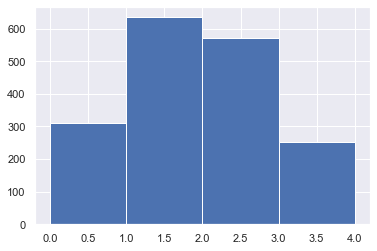

In [54]:
df_4.domain1_score.hist(bins=list(range(5)))
print(df_4.domain1_score.median(), df_4.domain1_score.mean())

In [55]:
df_5.domain1_score.describe()

count    1805.000000
mean        2.408864
std         0.970821
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: domain1_score, dtype: float64

2.0 2.4088642659279778


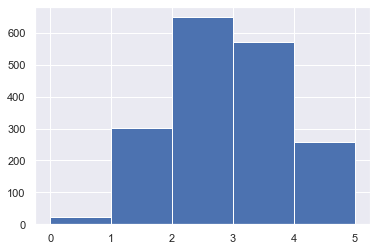

In [56]:
df_5.domain1_score.hist(bins=list(range(6)))
print(df_5.domain1_score.median(), df_5.domain1_score.mean())

In [57]:
df_6.domain1_score.describe()

count    1800.00000
mean        2.72000
std         0.97063
min         0.00000
25%         2.00000
50%         3.00000
75%         3.00000
max         4.00000
Name: domain1_score, dtype: float64

3.0 2.72


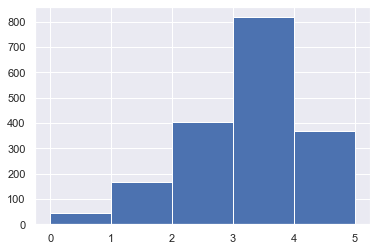

In [58]:
df_6.domain1_score.hist(bins=list(range(6)))
print(df_6.domain1_score.median(), df_6.domain1_score.mean())

In [59]:
df_7.domain1_score.describe()

count    1569.00000
mean       16.06246
std         4.58535
min         2.00000
25%        13.00000
50%        16.00000
75%        19.00000
max        24.00000
Name: domain1_score, dtype: float64

16.0 16.062460165710643


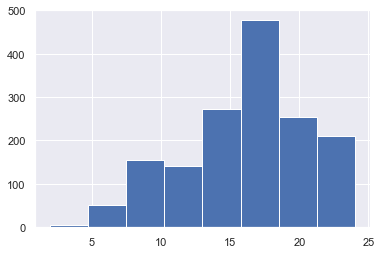

In [60]:
df_7.domain1_score.hist(bins=8)
print(df_7.domain1_score.median(), df_7.domain1_score.mean())

In [61]:
df_8.domain1_score.describe()

count    723.000000
mean      36.950207
std        5.753502
min       10.000000
25%       33.000000
50%       37.000000
75%       40.000000
max       60.000000
Name: domain1_score, dtype: float64

37.0 36.95020746887967


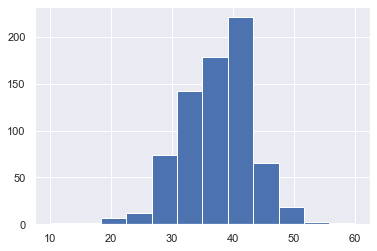

In [62]:
df_8.domain1_score.hist(bins=12)
print(df_8.domain1_score.median(), df_8.domain1_score.mean())

In [63]:
df2.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,1875,338,5.547337
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,2288,419,5.460621
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,1541,279,5.523297
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,3165,524,6.040076
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,2569,465,5.524731


In [64]:
df2['rater_diff'] = np.abs(df2.rater1_domain1 - df2.rater2_domain1)

In [65]:
df2.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len,rater_diff
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,1875,338,5.547337,0.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,2288,419,5.460621,1.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,1541,279,5.523297,1.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,3165,524,6.040076,0.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,2569,465,5.524731,0.0


In [66]:
df_1.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,1875,338,5.547337
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,2288,419,5.460621
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,1541,279,5.523297
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,3165,524,6.040076
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,2569,465,5.524731


In [67]:
df_8.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
12255,20716,8,A long time ago when I was in third grade I h...,18.0,16.0,34.0,3421,664,5.152108
12256,20717,8,Softball has to be one of the single most gre...,21.0,26.0,46.0,3963,780,5.080769
12257,20718,8,"Some people like making people laugh, I love ...",15.0,20.0,40.0,4397,848,5.185142
12258,20719,8,"""LAUGHTER"" @CAPS1 I hang out with my friends...",12.0,20.0,30.0,3415,705,4.843972
12259,20721,8,Well ima tell a story about the time i got @CA...,11.0,15.0,26.0,2943,645,4.562791


In [68]:
dfs = (df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8)
score_cols = ['rater1_domain1', 'rater2_domain1', 'domain1_score']

scaler = StandardScaler()

for df in dfs:
    for c in score_cols:
        df[c] = scaler.fit_transform(df[[c]])

<ipython-input-68-463a88f9796c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = scaler.fit_transform(df[[c]])
<ipython-input-68-463a88f9796c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = scaler.fit_transform(df[[c]])
<ipython-input-68-463a88f9796c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [69]:
df_1.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
0,1,1,"Dear local newspaper, I think effects computer...",-0.309778,-0.327828,-0.343483,1875,338,5.547337
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.878037,-0.327828,0.306655,2288,419,5.460621
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",-0.309778,-1.553231,-0.993622,1541,279,5.523297
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.878037,0.897575,0.956794,3165,524,6.040076
4,5,1,"Dear @LOCATION1, I know having computers has a...",-0.309778,-0.327828,-0.343483,2569,465,5.524731


In [70]:
df_8.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len
12255,20716,8,A long time ago when I was in third grade I h...,-0.106967,-0.807139,-0.513122,3421,664,5.152108
12256,20717,8,Softball has to be one of the single most gre...,0.840017,2.348953,1.574008,3963,780,5.080769
12257,20718,8,"Some people like making people laugh, I love ...",-1.053950,0.455298,0.530443,4397,848,5.185142
12258,20719,8,"""LAUGHTER"" @CAPS1 I hang out with my friends...",-2.000934,0.455298,-1.208832,3415,705,4.843972
12259,20721,8,Well ima tell a story about the time i got @CA...,-2.316595,-1.122748,-1.904542,2943,645,4.562791


In [71]:
rater1_series = df_1.rater1_domain1.append(df_2.rater1_domain1).append(df_3.rater1_domain1)\
                        .append(df_4.rater1_domain1).append(df_5.rater1_domain1).append(df_6.rater1_domain1)\
                        .append(df_7.rater1_domain1).append(df_8.rater1_domain1)
rater2_series = df_1.rater2_domain1.append(df_2.rater2_domain1).append(df_3.rater2_domain1)\
                        .append(df_4.rater2_domain1).append(df_5.rater2_domain1).append(df_6.rater2_domain1)\
                        .append(df_7.rater2_domain1).append(df_8.rater2_domain1)
domain1_score_series = df_1.domain1_score.append(df_2.domain1_score).append(df_3.domain1_score)\
                        .append(df_4.domain1_score).append(df_5.domain1_score).append(df_6.domain1_score)\
                        .append(df_7.domain1_score).append(df_8.domain1_score)
domain1_score_series

0       -0.343483
1        0.306655
2       -0.993622
3        0.956794
4       -0.343483
           ...   
12973   -0.339195
12974   -0.860977
12975    0.530443
12976    0.530443
12977    0.530443
Name: domain1_score, Length: 12973, dtype: float64

In [72]:
df2.rater1_domain1 = rater1_series
df2.rater2_domain1 = rater2_series
df2.domain1_score = domain1_score_series

In [73]:
df2.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len,rater_diff
0,1,1,"Dear local newspaper, I think effects computer...",-0.309778,-0.327828,-0.343483,1875,338,5.547337,0.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.878037,-0.327828,0.306655,2288,419,5.460621,1.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",-0.309778,-1.553231,-0.993622,1541,279,5.523297,1.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.878037,0.897575,0.956794,3165,524,6.040076,0.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",-0.309778,-0.327828,-0.343483,2569,465,5.524731,0.0


In [74]:
df2.isna().sum()

essay_id          0
essay_set         0
essay             0
rater1_domain1    0
rater2_domain1    0
domain1_score     0
num_char          0
num_word          0
avg_word_len      0
rater_diff        0
dtype: int64

In [75]:
df2 = df2.drop(['essay_id'], axis=1)

In [76]:
for i in ('!"#$%&' + "'()*+,-./:;<=>?@[\]^_`{|}~"):
    df2[str(i) + '_count'] = 0
    for row in range(len(df2)):
        df2.iloc[row,-1] = df2.iloc[row,1].count(i)

In [77]:
df2.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,num_char,num_word,avg_word_len,rater_diff,!_count,"""_count",#_count,$_count,%_count,&_count,'_count,(_count,)_count,*_count,+_count,",_count",-_count,._count,/_count,:_count,;_count,<_count,=_count,>_count,?_count,@_count,[_count,\_count,]_count,^_count,__count,`_count,{_count,|_count,}_count,~_count
0,1,"Dear local newspaper, I think effects computer...",-0.309778,-0.327828,-0.343483,1875,338,5.547337,0.0,4,0,0,0,0,0,5,1,1,0,0,18,2,10,6,1,0,0,0,0,2,5,0,0,0,0,0,0,0,0,0,0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.878037,-0.327828,0.306655,2288,419,5.460621,1.0,1,0,0,0,0,0,3,0,0,0,0,12,1,18,0,0,0,0,0,0,1,10,0,0,0,0,0,0,0,0,0,0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",-0.309778,-1.553231,-0.993622,1541,279,5.523297,1.0,0,0,0,0,0,0,4,0,0,0,0,9,0,14,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.878037,0.897575,0.956794,3165,524,6.040076,0.0,2,3,0,0,0,0,3,0,0,0,1,13,3,24,0,0,0,0,0,0,1,41,0,0,0,0,0,0,0,0,0,0
4,1,"Dear @LOCATION1, I know having computers has a...",-0.309778,-0.327828,-0.343483,2569,465,5.524731,0.0,0,0,0,0,0,0,5,0,0,0,0,13,2,30,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0


In [78]:
df2['nunique_word'] = 0

for i in range(len(df2)):
    df2.iloc[i,-1] = len(set(df2.iloc[i,1].split()))

In [79]:
df2['unique_word_frac'] = df2.nunique_word / df2.num_word

In [80]:
df2['num_sent'] = 0

for i in range(len(df2)):
    df2.iloc[i,-1] = len(nltk.sent_tokenize(df2.iloc[i,1]))

In [81]:
df2['avg_sent_len'] = df2.num_word / df2.num_sent

In [82]:
df2.columns

Index(['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'num_char', 'num_word', 'avg_word_len', 'rater_diff',
       '!_count', '"_count', '#_count', '$_count', '%_count', '&_count',
       ''_count', '(_count', ')_count', '*_count', '+_count', ',_count',
       '-_count', '._count', '/_count', ':_count', ';_count', '<_count',
       '=_count', '>_count', '?_count', '@_count', '[_count', '\_count',
       ']_count', '^_count', '__count', '`_count', '{_count', '|_count',
       '}_count', '~_count', 'nunique_word', 'unique_word_frac', 'num_sent',
       'avg_sent_len'],
      dtype='object')

In [83]:
df2 = df2.drop(['#_count', '$_count', '%_count', '*_count', '<_count', '=_count', '>_count', '[_count', 
                ']_count', '\_count', '^_count', '__count', '{_count', '|_count', '}_count', '~_count'], axis=1)

In [84]:
df2.columns

Index(['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'num_char', 'num_word', 'avg_word_len', 'rater_diff',
       '!_count', '"_count', '&_count', ''_count', '(_count', ')_count',
       '+_count', ',_count', '-_count', '._count', '/_count', ':_count',
       ';_count', '?_count', '@_count', '`_count', 'nunique_word',
       'unique_word_frac', 'num_sent', 'avg_sent_len'],
      dtype='object')

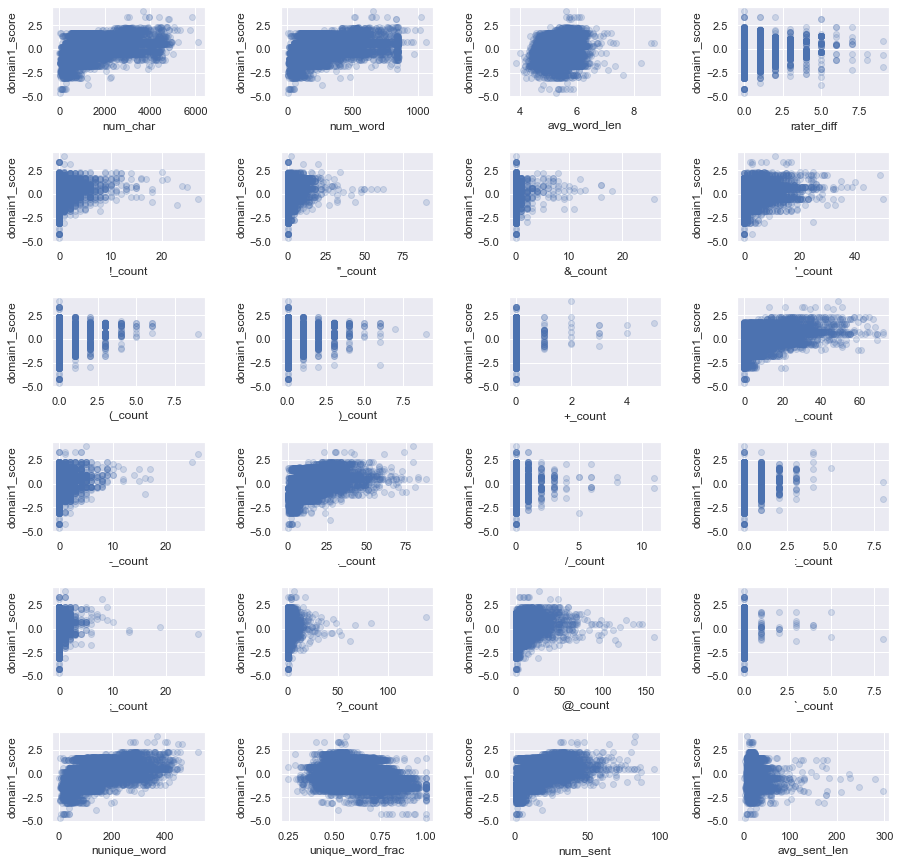

In [85]:
# Quick EDA for feature analysis.
scatterplots(columns = ['num_char', 'num_word', 'avg_word_len', 'rater_diff', '!_count', '"_count', 
                        '&_count', "'_count", '(_count', ')_count', '+_count', ',_count', '-_count', 
                        '._count', '/_count', ':_count', ';_count', '?_count', '@_count', '`_count', 
                        'nunique_word', 'unique_word_frac', 'num_sent', 'avg_sent_len'], 
             y_col = 'domain1_score', data=df2, ncol=4, figsize=(15, 15))

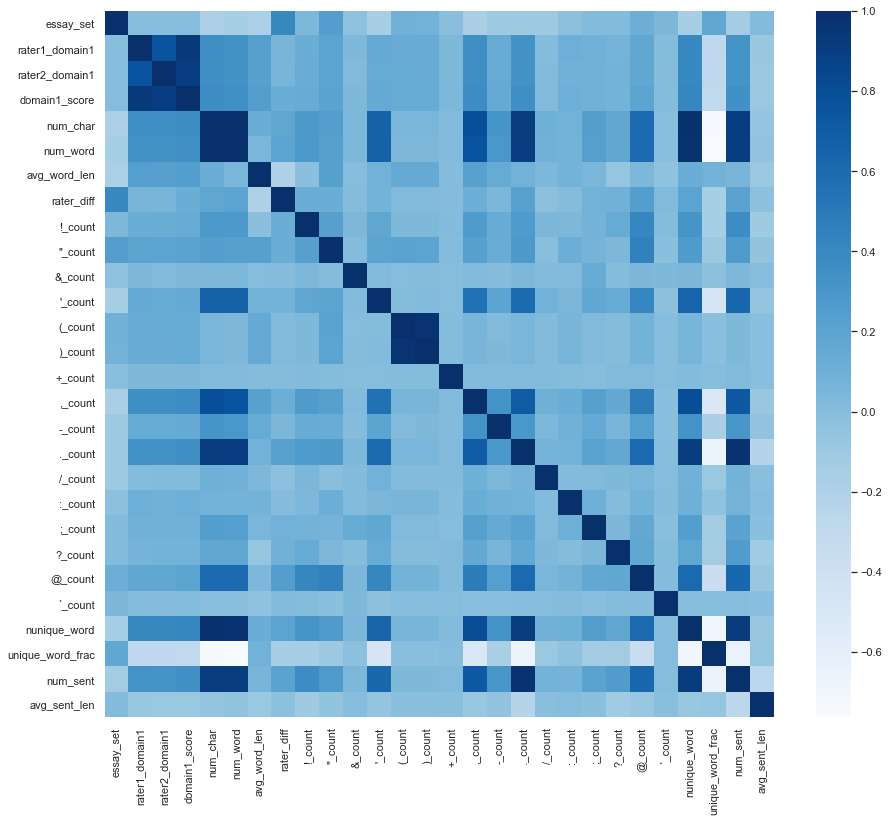

In [86]:
# Also EDA - heatmap
_ = plt.subplots(figsize=(15,13))
_ = sns.heatmap(df2.corr(), cmap='Blues')

In [87]:
X = df2[['num_char', 'num_word', 'avg_word_len', 'rater_diff', '!_count', '"_count', '&_count', "'_count", 
         '(_count', ')_count', '+_count', ',_count', '-_count', '._count', '/_count', ':_count', ';_count', 
         '?_count', '@_count', '`_count', 'nunique_word', 'unique_word_frac', 'num_sent', 'avg_sent_len']]
y = df2.domain1_score

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9729, 24) (3244, 24) (9729,) (3244,)


In [127]:
rf = RandomForestRegressor(n_estimators=500, max_depth=15, max_features=10, random_state=42, n_jobs=-1)

In [128]:
cv_score = cross_val_score(rf, X_train, y_train, cv=3)
print(cv_score, cv_score.mean(), cv_score.std())

[0.43364671 0.45973679 0.44594223] 0.4464419119143976 0.010657087849187397


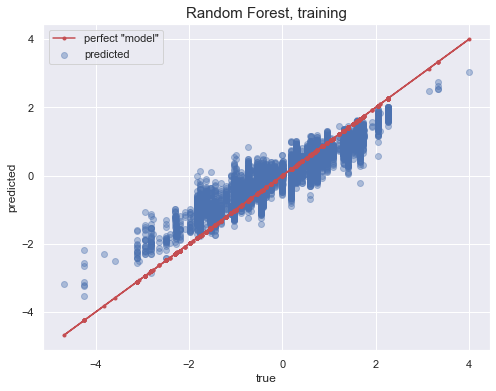

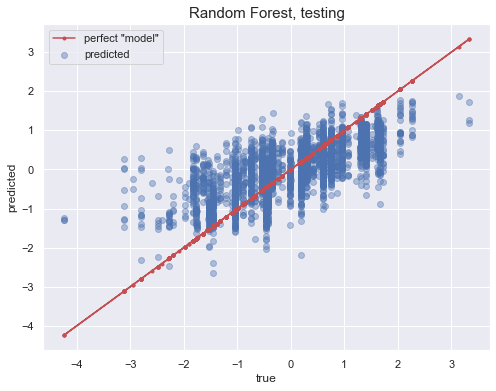

In [129]:
rf.fit(X_train, y_train)

# Predict Testing and Test sets using Lasso regression
y_tr_rf_pred = rf.predict(X_train)
y_te_rf_pred = rf.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, y_tr_rf_pred)
pred_plot("Random Forest, testing", y_test, y_te_rf_pred)

In [130]:
# Print test stats
test_stat("Random Forest", y_train, y_tr_rf_pred)

Random Forest : 
R^2:  0.8209
RMSE:  0.4238
MAE:  0.3312


In [131]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.4831
RMSE:  0.7153
MAE:  0.55


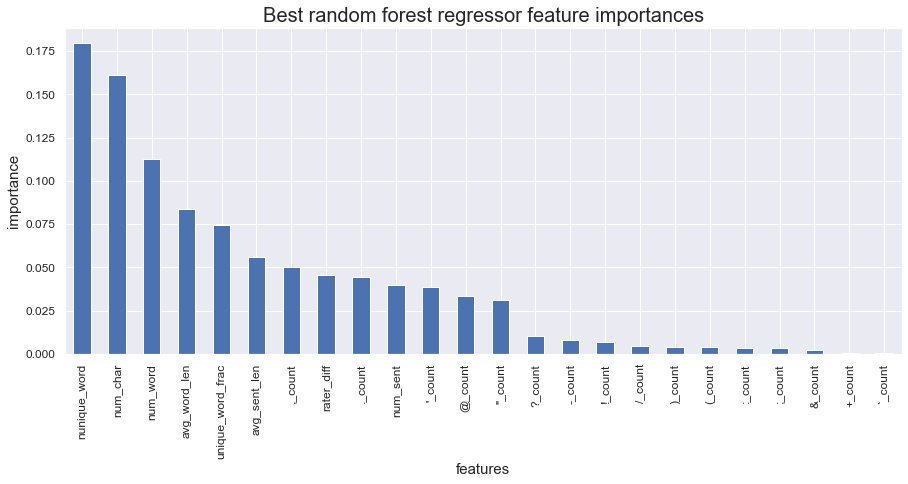

In [132]:
# Plot the feature importances.
plt.subplots(figsize=(15, 6))
imps = rf.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
_ = rf_feat_imps.plot(kind='bar', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

In [133]:
xgb.set_config(verbosity=0)

In [317]:
xg = XGBRegressor(colsample_bytree=0.5, alpha=10, min_child_weight=8, n_estimators=25, max_depth=5, num_boost_round=10, gamma=0.01, seed=42)

In [318]:
cv_score = cross_val_score(xg, X_train, y_train, cv=3)
print(cv_score, cv_score.mean(), cv_score.std())

[0.42894816 0.46638188 0.44158612] 0.44563872021593925 0.015548604869831232


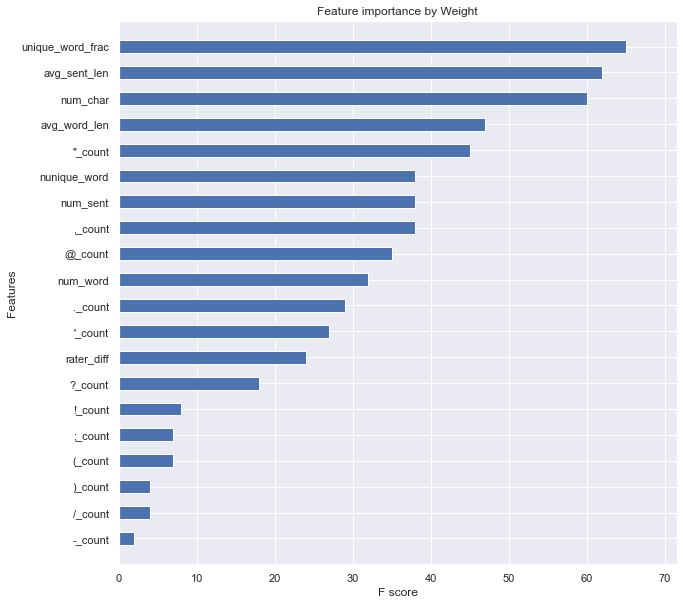

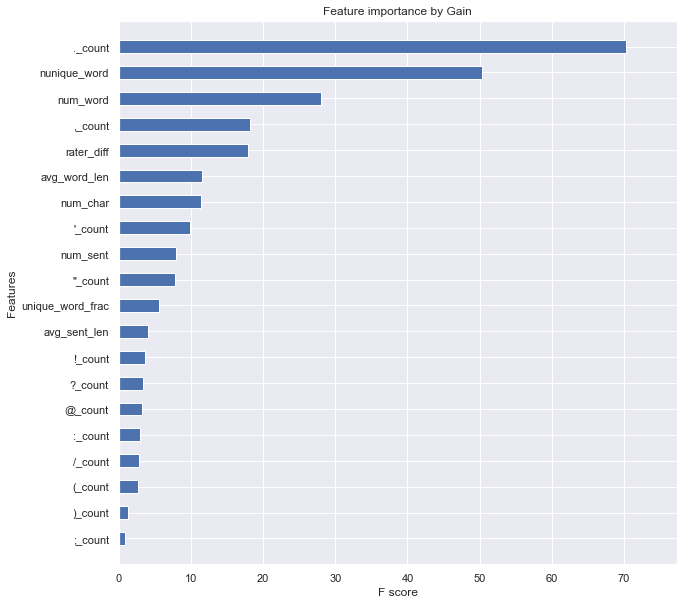

In [321]:
xg.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xg, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xg, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

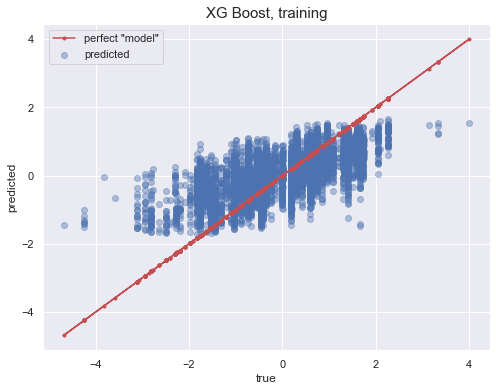

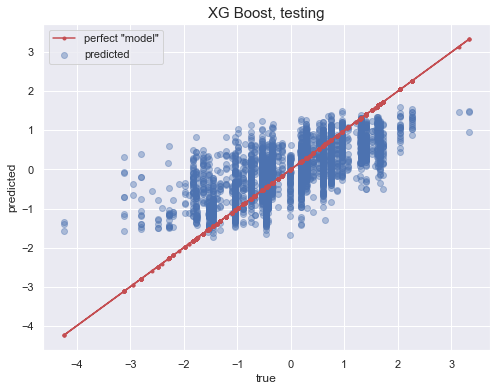

In [322]:
# Predict on Training and Test sets using Light GBM model
y_tr_xg_pred = xg.predict(X_train)
y_te_xg_pred = xg.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, y_tr_xg_pred)
pred_plot("XG Boost, testing", y_test, y_te_xg_pred)

In [323]:
# Print test stats
test_stat("XG Boost", y_train, y_tr_xg_pred)

XG Boost : 
R^2:  0.5153
RMSE:  0.6972
MAE:  0.5412


In [324]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.4815
RMSE:  0.7165
MAE:  0.555


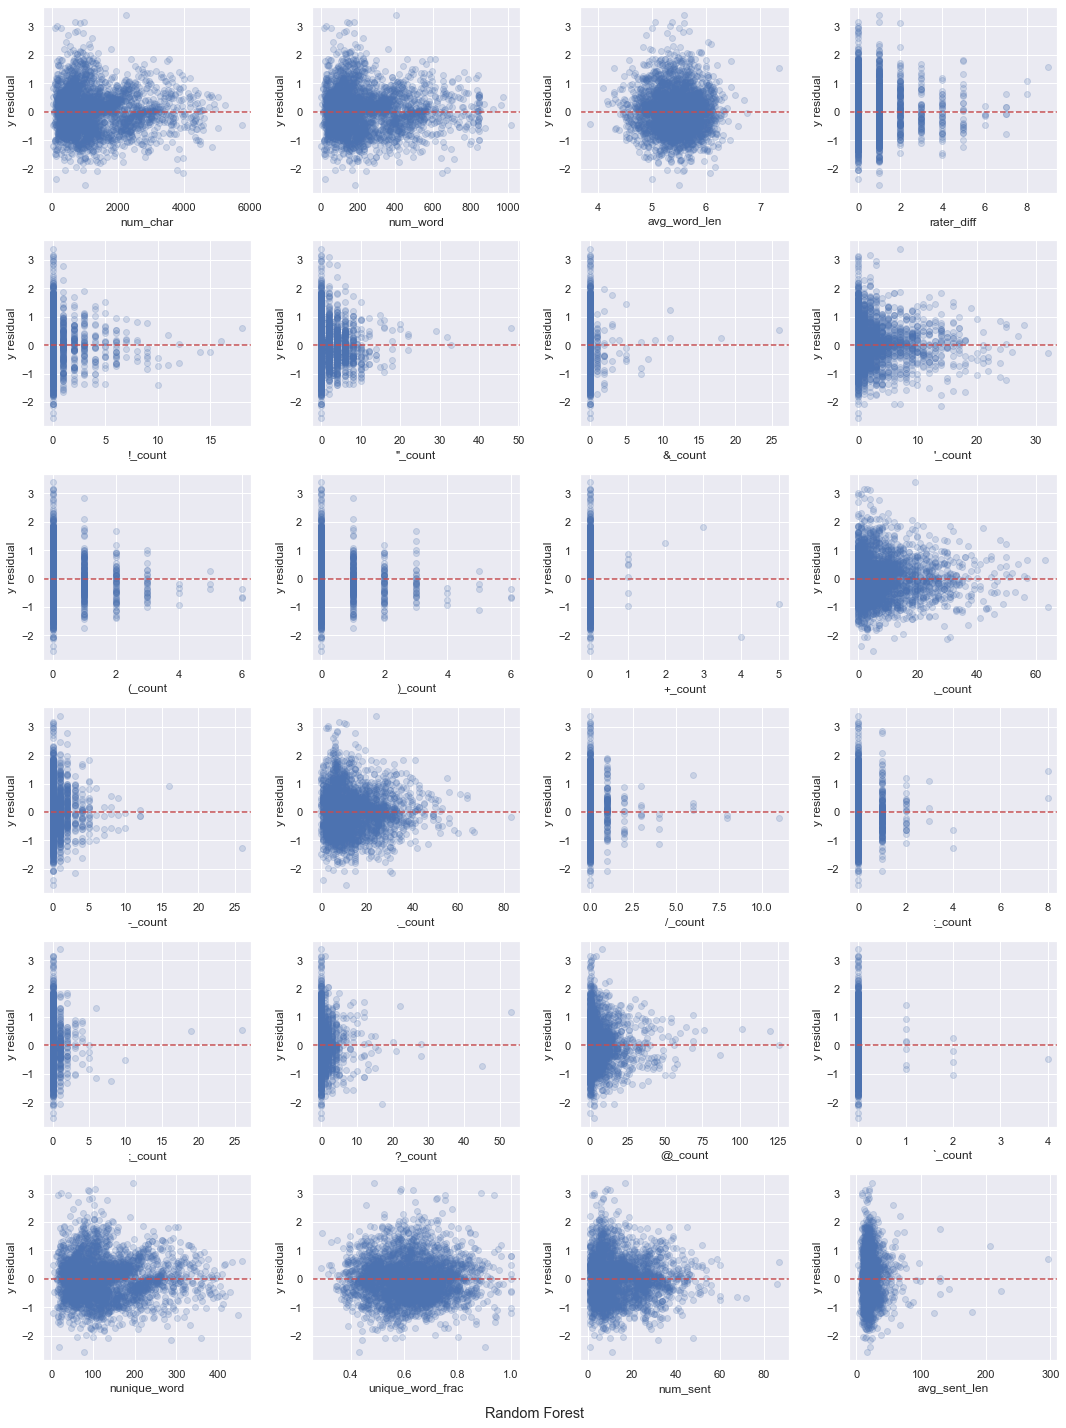

In [325]:
# Random Forest Testing prediction residuals
res_plot('Random Forest', X_test, y_test, y_te_rf_pred, ncol=4, figsize=(15,20))

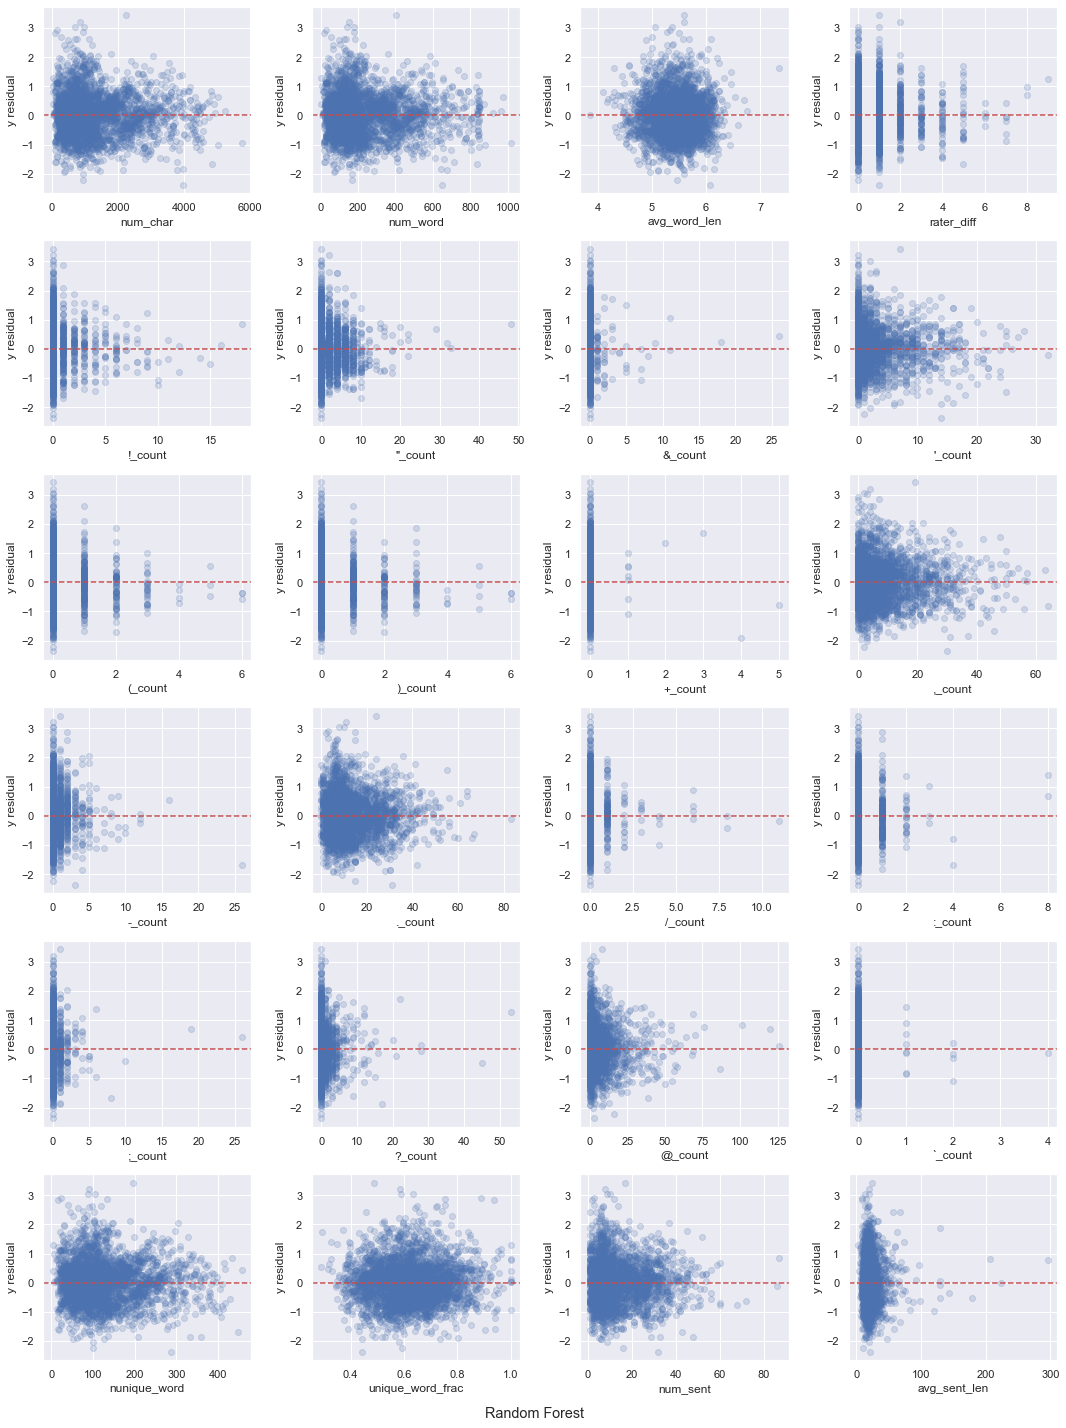

In [326]:
# Random Forest Testing prediction residuals
res_plot('Random Forest', X_test, y_test, y_te_xg_pred, ncol=4, figsize=(15,20))

In [327]:
X_tr_sc = X_train.copy()
X_te_sc = X_test.copy()

In [328]:
ptrans = PowerTransformer()

for c in X_tr_sc.columns:
    ptrans.fit(X_tr_sc[[c]])
    X_tr_sc[c] = ptrans.transform(X_tr_sc[[c]])
    X_te_sc[c] = ptrans.transform(X_te_sc[[c]])

In [330]:
lasso = Lasso(random_state=42)

# Parameter grid for pipeline - scaler is optional.
params = {
    'alpha': [n for n in np.logspace(-6,2,13)],
    'max_iter': [1000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(lasso, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'alpha': 0.0001, 'max_iter': 10000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,2.949771,0.034895,0.005321,0.000470,0.0001,10000,"{'alpha': 0.0001, 'max_iter': 10000}",0.294020,0.327190,0.308227,0.309812,0.013588,1
5,3.085409,0.095248,0.006322,0.000944,0.000022,10000,"{'alpha': 2.1544346900318823e-05, 'max_iter': ...",0.293965,0.327224,0.308231,0.309807,0.013624,2
3,3.349040,0.077308,0.005985,0.000814,0.000005,10000,"{'alpha': 4.641588833612782e-06, 'max_iter': 1...",0.293951,0.327231,0.308234,0.309805,0.013632,3
1,3.449438,0.167584,0.005985,0.000813,0.000001,10000,"{'alpha': 1e-06, 'max_iter': 10000}",0.293948,0.327232,0.308234,0.309805,0.013633,4
6,0.489024,0.023913,0.005320,0.000469,0.0001,1000,"{'alpha': 0.0001, 'max_iter': 1000}",0.293794,0.327264,0.308324,0.309794,0.013704,5


In [334]:
lasso_best = Lasso(alpha=0.0001, max_iter=10000)
lasso_best.fit(X_tr_sc, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.975509905661056, tolerance: 0.9758462450717824
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001, max_iter=10000)

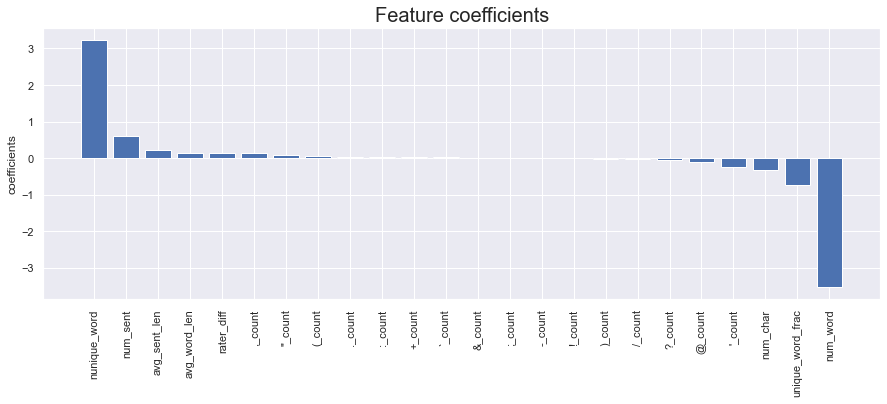

In [350]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_tr_sc.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0].sort_values(by='coef', ascending=False)

# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

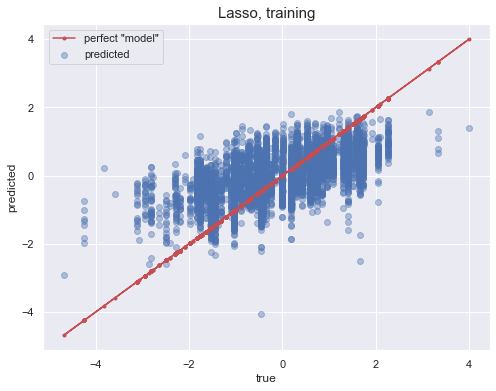

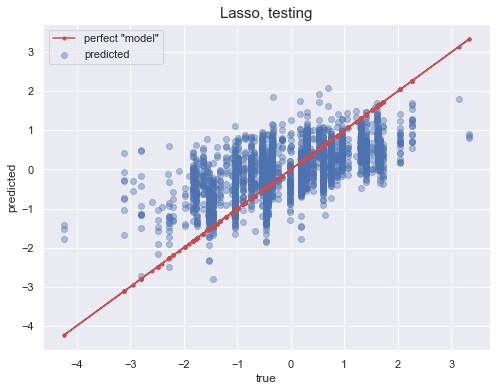

In [336]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_tr_sc)
y_te_lasso_pred = lasso_best.predict(X_te_sc)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, y_tr_lasso_pred)
pred_plot("Lasso, testing", y_test, y_te_lasso_pred)

In [337]:
# Print test stats for Lasso
test_stat("Lasso", y_train, y_tr_lasso_pred)

Lasso : 
R^2:  0.3632
RMSE:  0.7992
MAE:  0.6375


In [338]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.3867
RMSE:  0.7792
MAE:  0.6188


In [385]:
quadratic = PolynomialFeatures(2)
cubic = PolynomialFeatures(3)
quartic = PolynomialFeatures(4)
linreg = LinearRegression()

quadreg = make_pipeline(quadratic, linreg)

In [373]:
quadreg.fit(X_tr_sc, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

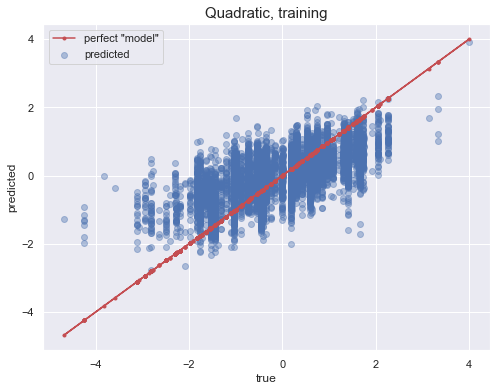

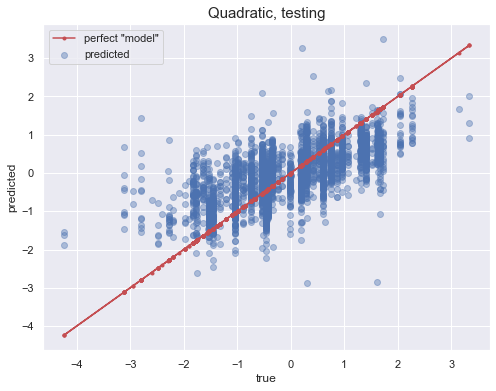

In [374]:
# Predict Testing and Test sets using Lasso regression
y_tr_quad_pred = quadreg.predict(X_tr_sc)
y_te_quad_pred = quadreg.predict(X_te_sc)

# Plot predicted vs true
pred_plot("Quadratic, training", y_train, y_tr_quad_pred)
pred_plot("Quadratic, testing", y_test, y_te_quad_pred)

In [375]:
# Print test stats for Lasso
test_stat("Quadratic", y_train, y_tr_quad_pred)

Quadratic : 
R^2:  0.4605
RMSE:  0.7356
MAE:  0.5759


In [376]:
# Print test stats for Lasso
test_stat("Quadratic", y_test, y_te_quad_pred)

Quadratic : 
R^2:  0.4251
RMSE:  0.7544
MAE:  0.5865


In [381]:
cubereg = make_pipeline(cubic, Lasso(alpha=0.001, random_state=42))

cubereg.fit(X_tr_sc, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.2405583708373, tolerance: 0.9758462450717824
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lasso', Lasso(alpha=0.001, random_state=42))])

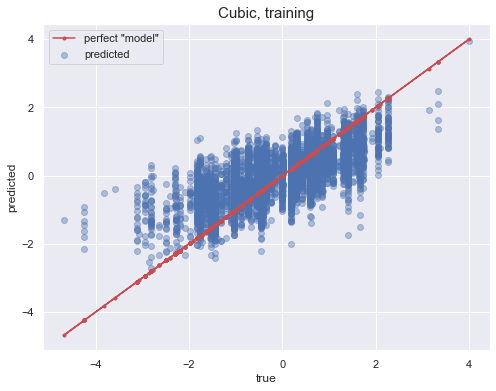

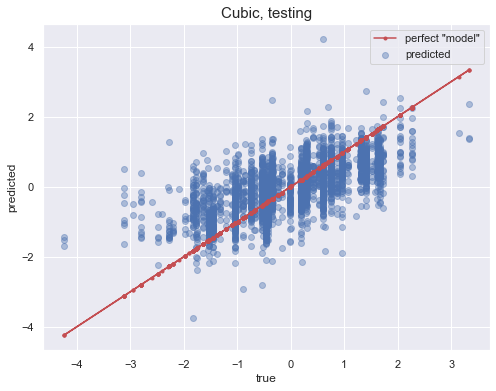

In [382]:
# Predict Testing and Test sets using Lasso regression
y_tr_cube_pred = cubereg.predict(X_tr_sc)
y_te_cube_pred = cubereg.predict(X_te_sc)

# Plot predicted vs true
pred_plot("Cubic, training", y_train, y_tr_cube_pred)
pred_plot("Cubic, testing", y_test, y_te_cube_pred)

In [383]:
# Print test stats for Lasso
test_stat("Cube", y_train, y_tr_cube_pred)

Cube : 
R^2:  0.5228
RMSE:  0.6918
MAE:  0.5362


In [384]:
# Print test stats for Lasso
test_stat("Cube", y_test, y_te_cube_pred)

Cube : 
R^2:  0.4188
RMSE:  0.7585
MAE:  0.5891


In [387]:
quartreg = make_pipeline(quartic, Lasso(alpha=0.01, random_state=42))

quartreg.fit(X_tr_sc, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.089634948521, tolerance: 0.9758462450717824
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('lasso', Lasso(alpha=0.01, random_state=42))])

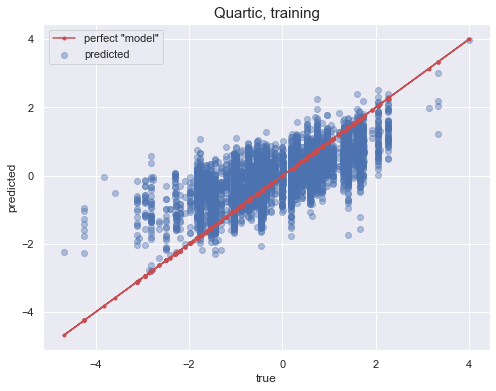

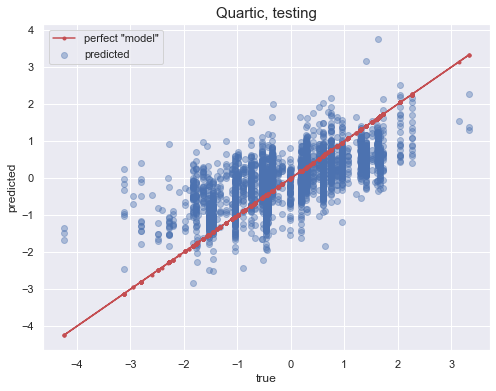

In [388]:
# Predict Testing and Test sets using Lasso regression
y_tr_quart_pred = quartreg.predict(X_tr_sc)
y_te_quart_pred = quartreg.predict(X_te_sc)

# Plot predicted vs true
pred_plot("Quartic, training", y_train, y_tr_quart_pred)
pred_plot("Quartic, testing", y_test, y_te_quart_pred)

In [389]:
# Print test stats for Lasso
test_stat("Quartic", y_train, y_tr_quart_pred)

Quartic : 
R^2:  0.5055
RMSE:  0.7043
MAE:  0.5494


In [390]:
# Print test stats for Lasso
test_stat("Quartic", y_test, y_te_quart_pred)

Quartic : 
R^2:  0.4358
RMSE:  0.7474
MAE:  0.5861
